In [4]:
import bz2
import json
from tqdm import tqdm

responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:54, 3715.85it/s]


In [5]:
import pandas as pd

df = pd.DataFrame(data=[pd.Series(responses[i]).values for i in range(len(responses))], columns=pd.Series(responses[0]).index.values)

In [6]:
# На самом деле основной проблемой явялется то, что одни и те же города могут быть записаны по-разному (не просто г. Москва, а, например, г. Москва, "Китай-город"), это ведет к неточности. Чтобы избежаьть этого необходимо пропустить названия городов через регулярку, скорее всего кастомную
df[['city', 'bank_name']].value_counts()

city                                 bank_name                
г. Москва                            Сбербанк России              8146
                                     Альфа-Банк                   3871
                                     Русский Стандарт             2801
                                     ВТБ 24                       2714
г. Санкт-Петербург                   Сбербанк России              2434
                                                                  ... 
г. Москва,  Отделение "Жулебинское"  Московский Кредитный Банк       1
г. Москва, "Китай-город"             Фора-Банк                       1
г. Москва, Ветошный пер              Восточный Экспресс Банк         1
г. Москва, Видное                    Сбербанк России                 1
г. … или другой населенный пункт     Лето Банк                       1
Length: 18769, dtype: int64

In [7]:
import re
from nltk.tokenize import word_tokenize

In [9]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
feedback_on_words = []
feedback_on_symbols = []

for feedback in df['text']:
    s = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]',  ' ',feedback)
    s = word_tokenize(s.lower())
    len_in_symb = 0
    for word in s: len_in_symb += len(word)
    feedback_on_words.append(len(s))
    feedback_on_symbols.append(len_in_symb)

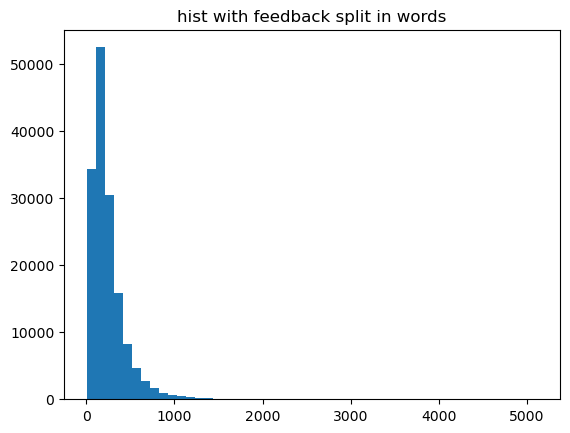

In [11]:
import matplotlib.pyplot as plt
plt.hist(feedback_on_words, bins=50)
plt.title(label='hist with feedback split in words')
plt.xlabel = 'length of feedbacks in words'
plt.ylabel = 'count'
plt.show()

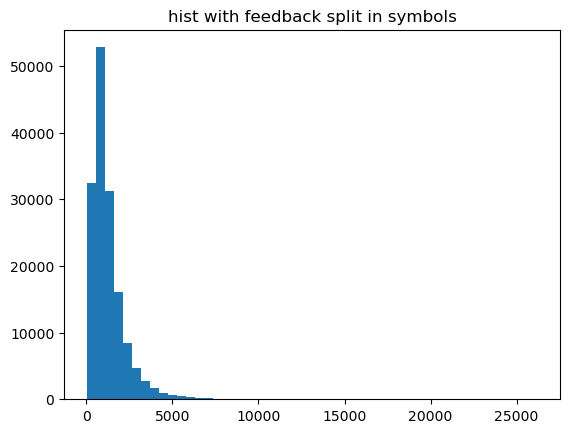

In [12]:
plt.hist(sorted(feedback_on_symbols), bins=50)
plt.title(label='hist with feedback split in symbols')
plt.xlabel = 'length of feedbacks in symbols'
plt.ylabel = 'count'
plt.show()

Как видно из полученных графиков полуенные гистограммы довольно схожи, это логично, ведь в среднем чем больше слов в предложении, тем больше в нем символов.  

In [15]:
from collections import Counter

all_words = []
for feedback in df['text']:
    s = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@^_`{|}~]',  ' ',feedback)
    all_words += word_tokenize(s.lower())

In [17]:
counter_ = Counter(all_words)

In [22]:
counter_.most_common(10)

[('в', 1330069),
 ('и', 1058651),
 ('не', 852394),
 ('на', 707750),
 ('что', 639972),
 ('я', 577384),
 ('с', 462212),
 ('по', 372707),
 ('мне', 320932),
 ('банка', 275642)]

In [23]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pavel\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [24]:
from nltk.corpus import stopwords
stopwords_ = stopwords.words('russian')

In [37]:
without_stop_words = [word for word in all_words if word not in stopwords_ and len(word) > 2]

counter_without_stop_words = Counter(without_stop_words)

In [38]:
counter_without_stop_words.most_common(10)

[('банка', 275642),
 ('банк', 215087),
 ('это', 183339),
 ('деньги', 131124),
 ('карту', 105768),
 ('карты', 101745),
 ('кредит', 81080),
 ('день', 76511),
 ('банке', 72038),
 ('заявление', 70392)]

In [27]:
from pymorphy2.analyzer import MorphAnalyzer

analyzer = MorphAnalyzer()

In [46]:
lemmas = [analyzer.parse(token)[0].normal_form for token in without_stop_words]

In [ ]:
lemmas_counter = Counter(lemmas)

In [ ]:
lemmas_counter.most_common(10)

'банк'

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])



clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD()), 
    ('clf', RandomForestClassifier())
])


NameError: name 'CountVectorizer' is not defined